In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

from src.preproces import *
from src.plotting import *
file_handler = Handle_Files()


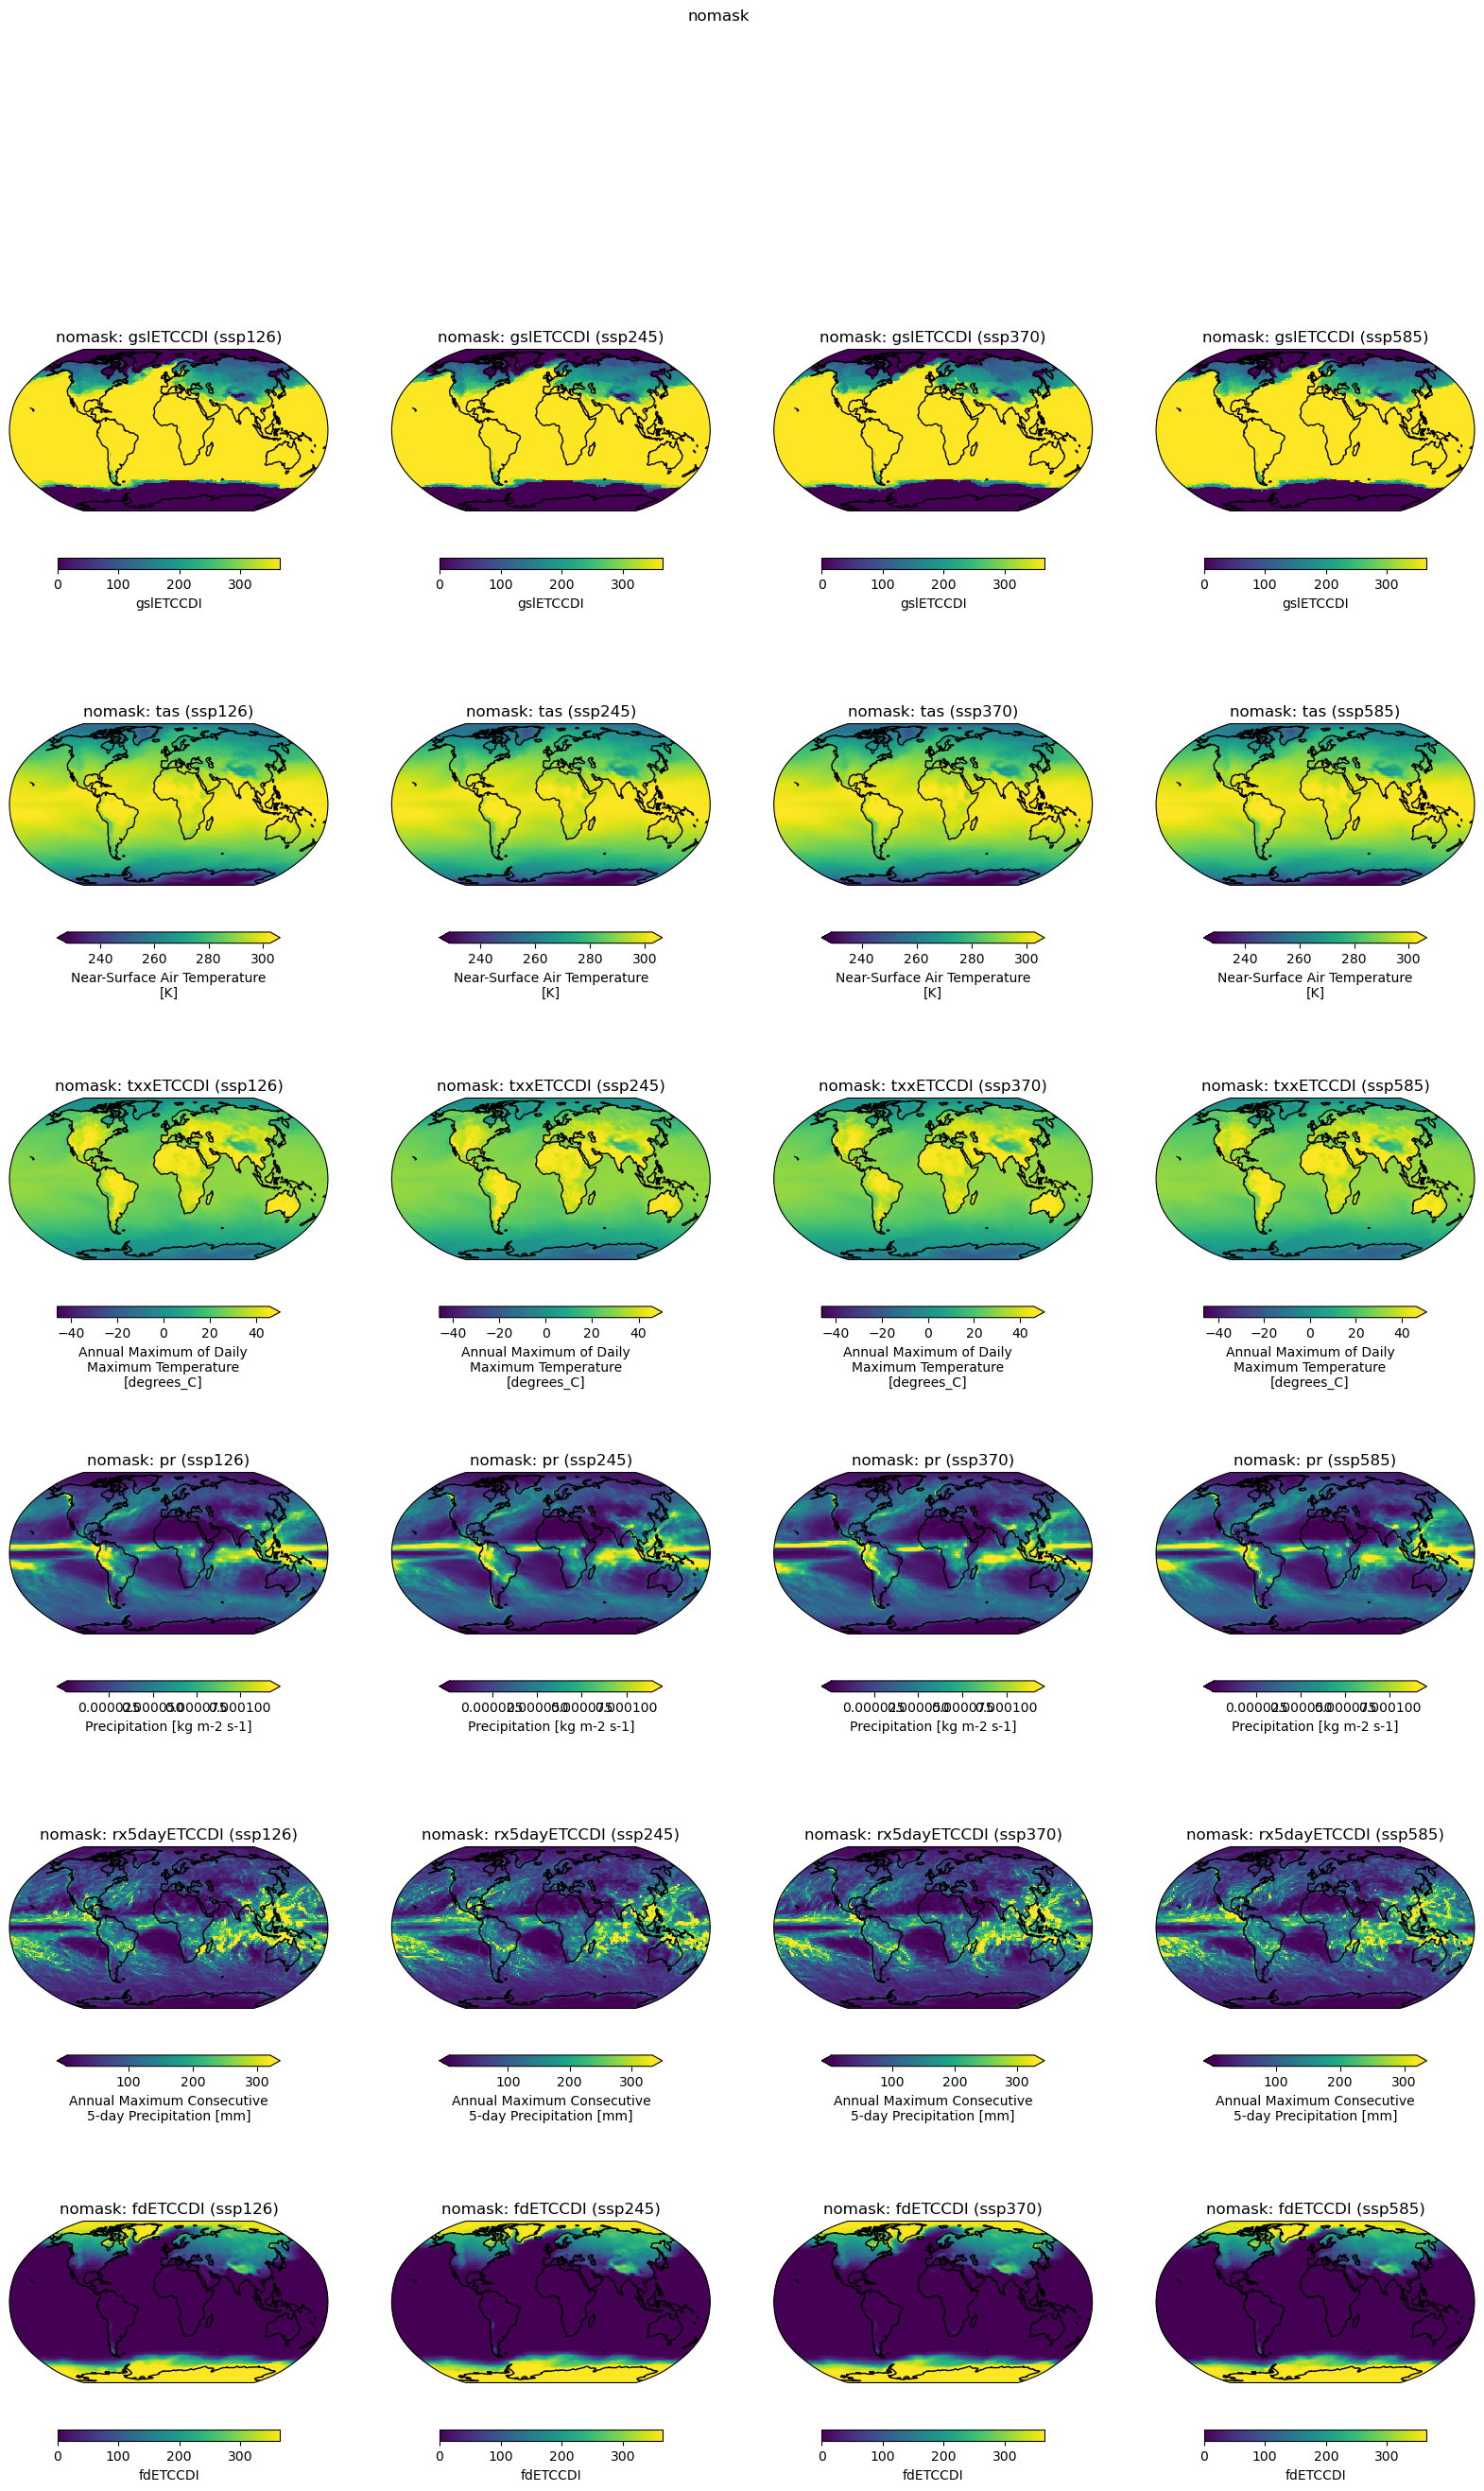

In [4]:
main_data_folder = '/nird/home/johannef/Masterthesis_S23 DataFiles/Annualclimatologies'
SSPs = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
all_masks = file_handler.get_all_filenames_in_dir(main_data_folder)
#all_masks = [mask for mask in all_masks if mask not in ['seamasked', 'landmasked']]

available_variables_in_mask = {mask: file_handler.get_all_filenames_in_dir('/'.join([main_data_folder, mask])) for mask in ['nomask']}



for mask, available_variables_list in available_variables_in_mask.items():
    n_rows = len(available_variables_list)
    n_cols = len(SSPs)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows), 
                            subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0), facecolor="gray"))
    fig.suptitle(f'{mask}')
    for row, var in enumerate(available_variables_list):
        print(c)
        for col, scenario in enumerate(SSPs):
            data_folder = '/'.join([main_data_folder, mask, var, scenario])
            sample_file = file_handler.read_netcdf_to_xr(directory=data_folder, file_name=file_handler.get_all_netcdf_files_in_dir(data_folder)[0]) 
            if n_rows == 1:
                ax = axs[col]
            else:
                ax = axs[row, col]

            plot_on_map(sample_file.isel(year=10)[var], ax, title=f'{mask}: {var} ({scenario})')
    
    plt.show()

# Test animation

In [1]:
from src.plotting import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import imageio.v2 as imageio

In [2]:
f_score_df = pd.read_csv('/nird/home/johannef/Masterthesis_S23 DataFiles/tables/feature_selection/f_scores.csv')
features = [col for col in f_score_df.columns if col not in ['year']]

In [42]:
def autolabel(ax, ranks):
        rects = ax.patches
        max_height = np.max([rect.get_height() for rect in rects])
        for rect, rank in zip(rects, ranks):
            rotation = 90
            height = rect.get_height()
            if height <= 0.25*max_height and height > 0.1*max_height:
                y = .5*height
            elif height <= 0.1*max_height and height > 0.05*max_height:
                y = .2*height
            elif height < 0.05*max_height:
                y = .8*height
                rotation = 0
            else:
                y = .8*height

            ax.text(rect.get_x() + rect.get_width() / 2., y,
                    rank,
                    ha='center', va='bottom', rotation=rotation, color='black')

In [62]:
def animate(scores_df, filter_name=None, save_folder=None):

    save_folder = save_folder if save_folder is not None else '/nird/home/johannef/Masterthesis_S23 Results/FigureFiles/Feature selection animations'
    png_files = []
    
    for indx, year in enumerate(scores_df['year']):
        scores_for_plotting = scores_df[(scores_df['year'] >= 2015) & (scores_df['year'] <= year)]
        scores_for_plotting = scores_for_plotting.drop('year', axis=1).sum().reset_index()
        scores_for_plotting.columns = ['var: mask', 'cumulative_score']
        scores_for_plotting['rank'] = scores_for_plotting['cumulative_score'].rank(ascending=False)
        scores_for_plotting['rank'] = scores_for_plotting['rank'].astype(int)
        scores_for_plotting['var'] = scores_for_plotting['var: mask'].str.split(':').str[0]
        
        fig, ax = plt.subplots(figsize=(12, 10))
        fig.suptitle(f'Cumulative {filter_name}-scores {year}:{scores_df["year"].iloc[-1]}', fontsize=20)

        sns.barplot(x=scores_for_plotting['var: mask'], y=scores_for_plotting['cumulative_score'], 
                    hue=scores_for_plotting['var'])
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='left')  # Rotate labels 90 degrees to the left
        plt.gca().set_xlabel(None)
        ax.set_ylabel('Cumulative score for var: mask')
        autolabel(ax, scores_for_plotting['rank'])
        plt.legend()
        plt.tight_layout()
        
        
        # saving 
        file_name = f'fig_{year}.png'
        png_files.append(file_name)
        if f'raw_imgs_{filter_name}' not in os.listdir(save_folder):
            os.makedirs('/'.join([save_folder, f'raw_imgs_{filter_name}']))
        plt.savefig('/'.join([save_folder, f'raw_imgs_{filter_name}', file_name]))
        plt.close()

    # create gif
    with imageio.get_writer('/'.join([save_folder, f'{filter_name}_scores_animation.gif']), mode='i', fps=2) as writer:
        for file_name in png_files:
            image = imageio.imread('/'.join([save_folder, f'raw_imgs_{filter_name}', file_name]))
            writer.append_data(image)
            os.remove('/'.join([save_folder, f'raw_imgs_{filter_name}', file_name]))
    
    os.removedirs('/'.join([save_folder, f'raw_imgs_{filter_name}']))

In [63]:
animate(f_score_df, 'f_classif')      

In [4]:
def plot_cumulative_mRMR_scores(mRMR_scores_df, title, period=None):
    def autolabel(rects, ranks):
        max_height = np.max([rect.get_height() for rect in rects])
        for rect, rank in zip(rects, ranks):
            height = rect.get_height()
            if height <= 0.25*max_height and height > 0.1*max_height:
                y = .5*height
            elif height <= 0.1*max_height:
                y = .2*height
            else:
                y = .8*height

            ax.text(rect.get_x() + rect.get_width() / 2., y,
                    rank,
                    ha='center', va='bottom', rotation=90, color='white')
    
    if period is not None:
        mRMR_scores_for_plotting = mRMR_scores_df[(mRMR_scores_df['year'] >= period[0]) & (mRMR_scores_df['year'] <= period[1])]
    else:
        mRMR_scores_for_plotting = mRMR_scores_df
    mRMR_scores_for_plotting = mRMR_scores_df.drop('year', axis=1).sum().reset_index()
    mRMR_scores_for_plotting.columns = ['var: mask', 'cumulative_mRMR_score']
    mRMR_scores_for_plotting['rank'] = mRMR_scores_for_plotting['cumulative_mRMR_score'].rank(ascending=False)
    mRMR_scores_for_plotting['rank'] = mRMR_scores_for_plotting['rank'].astype(int)
    mRMR_scores_for_plotting['var'] = mRMR_scores_for_plotting['var: mask'].str.split(':').str[0]

    # Plot the sum as a barplot with rank
    fig, ax = plt.subplots(figsize=(12, 8))  # Increase the figure size
    if period is not None:
        start_year = period[0]
        stop_year = period[1]
    else:
        start_year = mRMR_scores_df['year'].iloc[0]
        stop_year = mRMR_scores_df['year'].iloc[-1]
    
    fig.suptitle(title)
    sns.barplot(x=mRMR_scores_for_plotting['var: mask'], y=mRMR_scores_for_plotting['cumulative_mRMR_score'], 
                hue=mRMR_scores_for_plotting['var'])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='left')  # Rotate labels 90 degrees to the left
    ax.set_ylabel('Cumulative mRMR score for var: mask')
    autolabel(ax.patches, mRMR_scores_for_plotting['rank'])
    plt.legend()
    plt.show()

Progress:   0%|          | 0/100 [00:00<?, ?iteration/s]

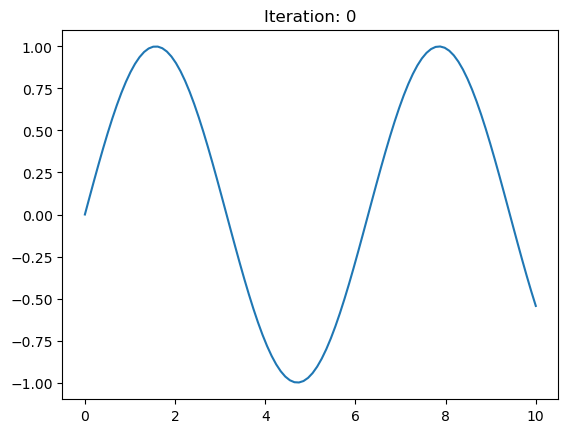

Progress: 100%|██████████| 100/100 [00:11<00:00,  8.34iteration/s]


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Create a sample data for demonstration
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Initialize tqdm with the total number of iterations
progress_bar = tqdm(range(100), desc="Progress", unit="iteration")

# Create a figure and plot the data
fig, ax = plt.subplots()
line, = ax.plot(x, y)

# Update the progress bar and redraw the plot for each iteration
for i in progress_bar:
    line.set_ydata(np.sin(x + i / 10.0))
    ax.set_title(f"Iteration: {i}")
    plt.pause(0.1)  # Pause to update the plot
    fig.canvas.draw()

plt.show()